## Video Classification For Shop Lifter

In [118]:
import os
import cv2
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random

# Video Dataset Preparation
This script creates a DataFrame from a directory of video files, then splits the data into training, validation, and test sets while maintaining label distribution.

In [2]:
# Function to create a DataFrame from the video dataset
def create_dataframe(data_dir):
    video_paths = []  # List to hold paths to video files
    labels = []       # List to hold corresponding labels

    # Loop through each class directory in the provided data directory
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)  # Create the full path to the class directory
        if os.path.isdir(class_dir):  # Check if the path is a directory
            # Loop through each video file in the class directory
            for video_file in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_file)  # Create the full path to the video file
                video_paths.append(video_path)  # Add the video path to the list
                labels.append(class_name)        # Add the label to the list

    # Create a DataFrame with video paths and their corresponding labels
    df = pd.DataFrame({'video_path': video_paths, 'label': labels})
    return df

# Create the DataFrame from the specified data directory
df = create_dataframe(r"C:\Users\HP\Downloads\Shop DataSet\Shop DataSet")

# Split the DataFrame into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Split the test set into validation and test sets
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['label'])

# Print the sizes of each dataset
print(f"Train data size: {len(train_df)}")
print(f"Validation data size: {len(val_df)}")
print(f"Test data size: {len(test_df)}")

Train data size: 684
Validation data size: 86
Test data size: 85


In [3]:
train_df

,video_path,label
796,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,shop lifters
145,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,non shop lifters
672,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,shop lifters
540,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,shop lifters
778,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,shop lifters
...,...,...
162,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,non shop lifters
709,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,shop lifters
847,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,shop lifters
597,C:\Users\HP\Downloads\Shop DataSet\Shop DataSe...,shop lifters


# Video Frame Dimension Retrieval
This code retrieves and prints the width and height of the frames in a specified video file.

In [4]:
# Function to get the dimensions of the frames in a video
def get_video_frame_dimensions(video_path):
    try:
        cap = cv2.VideoCapture(video_path)  # Open the video file
        if not cap.isOpened():  # Check if the video was opened successfully
            return None
        
        # Retrieve the width and height of the video frames
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        cap.release()  # Release the video capture object
        return width, height  # Return the dimensions
    except Exception as e:
        print(f"Error opening video {video_path}: {e}")  # Print any error that occurs
        return None

# Example usage:
video_path = df['video_path'][0]  # Get the path of the first video in the DataFrame
frame_dimensions = get_video_frame_dimensions(video_path)  # Retrieve frame dimensions

# Print the results
if frame_dimensions:
    width, height = frame_dimensions
    print(f"Video frame dimensions: Width = {width}, Height = {height}")
else:
    print("Could not retrieve video frame dimensions.")

Video frame dimensions: Width = 704, Height = 576


In [5]:
# Sum Video for every class
video_counts_per_class = df.groupby('label')['video_path'].count()
print(video_counts_per_class)


label
non shop lifters    531
shop lifters        324
Name: video_path, dtype: int64


# Frame Display from Video
This code opens a specified video file and displays a specified frame after resizing it to 320x320 pixels.


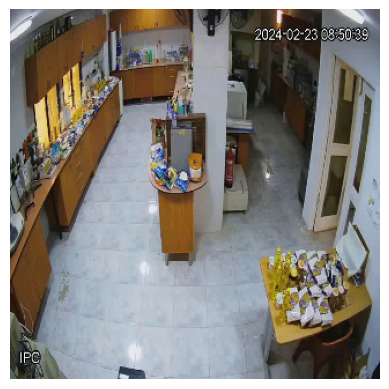

In [6]:
# Function to display a specific frame from a video
def display_frame(video_path, frame_number=0):
    try:
        cap = cv2.VideoCapture(video_path)  # Open the video file
        if not cap.isOpened():  # Check if the video was opened successfully
            print("Error opening video.")
            return

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)  # Set the position to the desired frame
        ret, frame = cap.read()  # Read the frame

        if ret:  # Check if the frame was read successfully
            # Resize the frame to 320x320 pixels for display
            resized_frame = cv2.resize(frame, (320, 320))
            
            # Convert from BGR (OpenCV default) to RGB for proper display
            rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

            # Display the frame using Matplotlib
            plt.imshow(rgb_frame)
            plt.axis('off')  # Hide axes for a cleaner look
            plt.show()  # Show the image

        else:
            print("Could not read frame.")  # Handle the case where the frame could not be read

        cap.release()  # Release the video capture object
    except Exception as e:
        print(f"Error: {e}")  # Print any errors that occur

# Example usage:
video_path = df['video_path'][0]  # Replace with your video path
display_frame(video_path)  # Call the function to display the frame

# Video Frame Count Analysis
This code counts the number of frames in each video file and displays how many videos share the same frame count.


In [7]:
# Function to get the number of frames in a video
def get_video_frame_count(video_path):
    try:
        cap = cv2.VideoCapture(video_path)  # Open the video file
        if not cap.isOpened():  # Check if the video was opened successfully
            return None
        
        # Retrieve the total frame count
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()  # Release the video capture object
        return frame_count  # Return the frame count
    except Exception as e:
        print(f"Error opening video {video_path}: {e}")  # Print any error that occurs
        return None

# Dictionary to hold frame counts and the number of videos with that count
frame_counts = {}

# Iterate over each video path in the DataFrame
for video_path in df['video_path']:
    frame_count = get_video_frame_count(video_path)  # Call the function to get the frame count
    if frame_count is not None:  # Check if the frame count was retrieved successfully
        # Increment the count for this specific frame count in the dictionary
        if frame_count not in frame_counts:
            frame_counts[frame_count] = 0
        frame_counts[frame_count] += 1

# Print the number of videos with the same frame count
print("Number of videos with the same frame count:")
for frame_count, count in frame_counts.items():
    print(f"{frame_count} frames: {count} videos")  # Output the results

Number of videos with the same frame count:
450 frames: 27 videos
475 frames: 21 videos
400 frames: 53 videos
300 frames: 63 videos
275 frames: 70 videos
350 frames: 60 videos
175 frames: 17 videos
150 frames: 8 videos
250 frames: 67 videos
425 frames: 41 videos
325 frames: 60 videos
225 frames: 33 videos
200 frames: 40 videos
1850 frames: 2 videos
375 frames: 66 videos
550 frames: 2 videos
125 frames: 2 videos
500 frames: 15 videos
525 frames: 8 videos
650 frames: 2 videos
75 frames: 2 videos
575 frames: 2 videos
900 frames: 2 videos
625 frames: 2 videos
472 frames: 1 videos
274 frames: 7 videos
373 frames: 15 videos
348 frames: 11 videos
398 frames: 9 videos
298 frames: 8 videos
249 frames: 13 videos
423 frames: 3 videos
323 frames: 11 videos
199 frames: 1 videos
596 frames: 1 videos
447 frames: 2 videos
174 frames: 6 videos
224 frames: 3 videos
322 frames: 5 videos
223 frames: 9 videos
347 frames: 4 videos
372 frames: 10 videos
421 frames: 4 videos
495 frames: 4 videos
396 frames: 1

In [8]:
# Sorted form small frame to big
frame_counts_list = [(frame_count, count) for frame_count, count in frame_counts.items()]
frame_counts_list.sort()
print("Number of videos with the same frame count (sorted by frame count):")
for frame_count, count in frame_counts_list:
  print(f"{frame_count} frames: {count} videos")

Number of videos with the same frame count (sorted by frame count):
75 frames: 2 videos
100 frames: 1 videos
125 frames: 2 videos
150 frames: 8 videos
174 frames: 6 videos
175 frames: 17 videos
198 frames: 8 videos
199 frames: 1 videos
200 frames: 40 videos
223 frames: 9 videos
224 frames: 3 videos
225 frames: 33 videos
248 frames: 18 videos
249 frames: 13 videos
250 frames: 67 videos
273 frames: 12 videos
274 frames: 7 videos
275 frames: 70 videos
297 frames: 5 videos
298 frames: 8 videos
300 frames: 63 videos
322 frames: 5 videos
323 frames: 11 videos
325 frames: 60 videos
347 frames: 4 videos
348 frames: 11 videos
350 frames: 60 videos
372 frames: 10 videos
373 frames: 15 videos
375 frames: 66 videos
396 frames: 14 videos
398 frames: 9 videos
400 frames: 53 videos
421 frames: 4 videos
423 frames: 3 videos
425 frames: 41 videos
446 frames: 3 videos
447 frames: 2 videos
450 frames: 27 videos
471 frames: 1 videos
472 frames: 1 videos
475 frames: 21 videos
495 frames: 4 videos
500 frame

This script removes videos from a DataFrame if their frame counts match specified target values, updating the DataFrame accordingly.


In [111]:
# Specify the frame counts to target
target_frame_counts = [75, 100, 125, 150, 174, 175, 900, 1850]
videos_to_remove = []  # Initialize an empty list to store videos to be removed

# Loop through the video paths to find and print the videos with specified frame counts
for video_path in df['video_path']:
    frame_count = get_video_frame_count(video_path)  # Get the frame count for the current video
    # Check if the frame count is in the list of target frame counts
    if frame_count in target_frame_counts:
        videos_to_remove.append(video_path)  # Add the video to the removal list
        print(f"Video to be removed (contains {frame_count} frames): {video_path}")

# Remove the identified videos from the DataFrame
df = df[~df['video_path'].isin(videos_to_remove)]  # Filter out videos to be removed
print(f"DataFrame size after removing videos: {len(df)}")  # Print the new size of the DataFrame

DataFrame size after removing videos: 815


In [11]:
video_counts_per_class = df.groupby('label')['video_path'].count()
print(video_counts_per_class)

label
non shop lifters    509
shop lifters        306
Name: video_path, dtype: int64


This Python script creates directories for processed videos (training, validation, and testing) if they do not already exist, ensuring organized dataset storage.

In [12]:
# Function to create directories if they do not exist
def create_save_dirs(base_dir):
    # Define the paths for training, validation, and testing directories
    train_dir = os.path.join(base_dir, 'processed_videos_train')
    val_dir = os.path.join(base_dir, 'processed_videos_val')
    test_dir = os.path.join(base_dir, 'processed_videos_test')

    # Create the directories if they do not already exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Return the paths of the created directories
    return train_dir, val_dir, test_dir

# Use the function to create directories on Google Drive
base_dir = r'C:\Users\HP\Desktop\Shop_Dataset_Processed' 
train_save_dir, val_save_dir, test_save_dir = create_save_dirs(base_dir)

This load_and_process_video function loads a video from a specified path, processes each frame by resizing and converting the color format, and adjusts the total number of frames to match a target count for consistent input to a model. The reduce_frames function reduces the number of frames in a video through balanced selection and increase_frames is to increase the number of frames by linearly interpolating between existing frames, along with save_processed_video function to save the processed frames as a NumPy array file.

In [13]:
# Function to load and process a video
def load_and_process_video(path, target_frames=150, resize=(200, 200)):
    cap = cv2.VideoCapture(path)  # Open the video file
    frames = []  # List to store processed frames
    try:
        while True:
            ret, frame = cap.read()  # Read a frame from the video
            if not ret:  # Break the loop if there are no frames left
                break
            frame = cv2.resize(frame, resize)  # Resize the frame
            frame = frame[:, :, [2, 1, 0]]  # Convert BGR to RGB
            frames.append(frame)  # Append the processed frame to the list
    finally:
        cap.release()  # Release the video capture object

    current_frames = len(frames)  # Count the current number of frames
    
    # Adjust the number of frames to match target_frames
    if current_frames > target_frames:
        frames = reduce_frames(frames, target_frames)  # Reduce the number of frames
    elif current_frames < target_frames:
        frames = increase_frames(frames, target_frames)  # Increase the number of frames
    
    return np.array(frames)  # Return the processed frames as a NumPy array

# Function to reduce the number of frames in a balanced way
def reduce_frames(frames, target_frames):
    total_frames = len(frames)  # Get the total number of frames
    indices = np.linspace(0, total_frames - 1, target_frames).astype(int)  # Calculate evenly spaced indices
    reduced_frames = [frames[i] for i in indices]  # Select frames based on calculated indices
    return reduced_frames  # Return the reduced frames

# Function to increase the number of frames by adding frames between existing frames
def increase_frames(frames, target_frames):
    total_frames = len(frames)  # Get the total number of frames
    result = []  # List to store the resulting frames
    
    for i in range(total_frames - 1):
        result.append(frames[i])  # Append the current frame to the result
        
        # Calculate the number of frames to add between frames[i] and frames[i + 1]
        num_extra_frames = (target_frames - len(result) - (total_frames - i - 1)) // (total_frames - i - 1)
        
        if num_extra_frames > 0:  # Check if extra frames need to be added
            for j in range(1, num_extra_frames + 1):
                # Linearly interpolate between frames[i] and frames[i + 1]
                alpha = j / (num_extra_frames + 1)
                interpolated_frame = (1 - alpha) * frames[i] + alpha * frames[i + 1]
                result.append(interpolated_frame.astype(np.uint8))  # Append the interpolated frame
    
    result.append(frames[-1])  # Always add the last frame
    
    # If we haven't reached target_frames, fill with extra copies of the last frame
    while len(result) < target_frames:
        result.append(frames[-1])
    
    return result  # Return the resulting frames

# Function to save the processed video frames to a .npy file
def save_processed_video(frames, save_path):
    np.save(save_path, frames)  # Save the frames as a NumPy array

This function processes videos from a DataFrame, saves them as NumPy arrays with assigned labels, and skips already processed videos to ensure efficient handling of the dataset.

In [113]:
# Function to preprocess videos and save them as .npy files
def preprocess_and_save_videos(df, video_column, target_frames=150, resize=(200, 200), save_dir='processed_videos'):
    # Ensure the output directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    for index, row in tqdm.tqdm(df.iterrows(), total=len(df)):  # Iterate over each row in the DataFrame
        path = row[video_column]  # Get the video path from the specified column
        
        # Assign label based on the value in the DataFrame
        if row['label'] == 'shop lifters':
            label = 1  # Label for shop lifters
        else:
            label = 0  # Label for others
        
        save_path = os.path.join(save_dir, f"video_{index}_label_{label}.npy")  # Create a save path for the processed video
        
        # Check if the video has already been processed and saved
        if os.path.exists(save_path):
            #print(f"Skipping {save_path}, already processed.")  # Uncomment for debugging
            continue  # Skip to the next video if already processed
        
        # Process and save the video
        frames = load_and_process_video(path, target_frames=target_frames, resize=resize)  # Load and process the video frames
        save_processed_video(frames, save_path)  # Save the processed frames as a .npy file
    
    print(f"Videos have been processed and saved in {save_dir}")  # Print a message indicating completion

# Load training, validation, and test data
preprocess_and_save_videos(train_df, 'video_path', save_dir=train_save_dir)
preprocess_and_save_videos(val_df, 'video_path', save_dir=val_save_dir)
preprocess_and_save_videos(test_df, 'video_path', save_dir=test_save_dir)


100%|██████████| 684/684 [00:00<00:00, 11336.58it/s]


Videos have been processed and saved in C:\Users\HP\Desktop\Shop_Dataset_Processed\processed_videos_train


100%|██████████| 86/86 [00:00<00:00, 9659.38it/s]


Videos have been processed and saved in C:\Users\HP\Desktop\Shop_Dataset_Processed\processed_videos_val


100%|██████████| 85/85 [00:00<00:00, 6522.55it/s]

Videos have been processed and saved in C:\Users\HP\Desktop\Shop_Dataset_Processed\processed_videos_test


This code defines a function to load saved video data from specified directories while handling errors and using memory-mapped loading for efficiency. It then loads training, validation, and test datasets, printing their shapes to confirm successful loading.

In [114]:
# Function to load saved videos with memory-mapped mode and proper error handling
def load_saved_videos(save_dir, mmap_mode='r'):
    video_data = []  # List to hold video data
    labels = []  # List to hold corresponding labels
    
    for file_name in tqdm.tqdm(os.listdir(save_dir)):  # Iterate through files in the directory
        if file_name.endswith('.npy'):  # Check if the file is a .npy file
            file_path = os.path.join(save_dir, file_name)  # Create the full file path
            
            try:
                # Use memory-mapped loading for large files
                frames = np.load(file_path, mmap_mode=mmap_mode)  # Load the video frames
                video_data.append(frames)  # Append frames to video_data
                
                # Extract the label from the filename (assuming format video_{index}_label_{label}.npy)
                parts = file_name.split('_')
                
                if len(parts) > 3:  # Ensure correct filename format
                    label = parts[-1].split('.')[0]  # Get the last part before the extension
                else:
                    raise ValueError(f"Filename format error: {file_name}")
                
                labels.append(label)  # Append label to the labels list
            
            except Exception as e:  # Catch any loading errors
                print(f"Error loading {file_name}: {str(e)}")
                continue  # Skip to the next file if there's an error
    
    # Try to convert to NumPy arrays
    try:
        video_data = np.array(video_data)  # Convert video data list to NumPy array
        labels = np.array(labels)  # Convert labels list to NumPy array
        print(f"Successfully converted data to NumPy arrays. Total videos: {len(video_data)}")
    except ValueError as e:  # Handle conversion errors
        print(f"Error converting to array: {str(e)}")
        print("Returning lists of video data and labels instead of arrays.")
        return video_data, labels

    return video_data, labels  # Return the video data and labels

# Load training, validation, and test datasets
train_video_data, train_labels = load_saved_videos(r"C:\Users\HP\Desktop\Shop_Dataset_Processed\processed_videos_train")
val_video_data, val_labels = load_saved_videos(r"C:\Users\HP\Desktop\Shop_Dataset_Processed\processed_videos_val")
test_video_data, test_labels = load_saved_videos(r"C:\Users\HP\Desktop\Shop_Dataset_Processed\processed_videos_test")

# Print the shapes of the loaded datasets
print(f"Train data shape: {train_video_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_video_data.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test data shape: {test_video_data.shape}, Test labels shape: {test_labels.shape}")

100%|██████████| 684/684 [00:00<00:00, 1269.87it/s]


Successfully converted data to NumPy arrays. Total videos: 684


100%|██████████| 86/86 [00:00<00:00, 686.10it/s]


Successfully converted data to NumPy arrays. Total videos: 86


100%|██████████| 85/85 [00:00<00:00, 1248.98it/s]


Successfully converted data to NumPy arrays. Total videos: 85
Train data shape: (684, 150, 200, 200, 3), Train labels shape: (684,)
Validation data shape: (86, 150, 200, 200, 3), Validation labels shape: (86,)
Test data shape: (85, 150, 200, 200, 3), Test labels shape: (85,)


In [16]:
# Check the unique labels
print(np.unique(train_labels))
print(np.unique(val_labels))
print(np.unique(test_labels))
print(train_labels)

['0' '1']
['0' '1']
['0' '1']
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' 

This code defines a video generator function that yields batches of video frames and their corresponding labels for training, incorporating optional data augmentation techniques to enhance model robustness. The generator allows for random shuffling of videos and the application of transformations such as rotation and zoom to prevent overfitting during training.

In [17]:
def video_generator(video_data, labels, batch_size, augment=False, datagen=None, smoothing_factor=0.1):
    """
    Improved video generator function that yields batches of video frames and labels for training, with additional augmentations
    and overfitting prevention mechanisms like label smoothing and temporal augmentation.
    
    Parameters:
    - video_data: Preprocessed video data (train, val, or test)
    - labels: Corresponding labels for the video data
    - batch_size: Number of samples per batch
    - augment: Boolean flag to indicate if data augmentation should be applied
    - datagen: Augmentation generator (if augment is True)
    - smoothing_factor: Smoothing factor for labels to prevent overfitting
    
    Yields:
    - batch_videos: A batch of videos (as NumPy arrays)
    - batch_labels: Corresponding smoothed labels for the batch
    """
    
    while True:  # Infinite loop to continuously yield batches
        # Shuffle the data indices
        indices = np.arange(len(video_data))
        np.random.shuffle(indices)  # Shuffle the indices for random sampling
        
        for i in range(0, len(video_data), batch_size):
            batch_indices = indices[i:i + batch_size]  # Get indices for the current batch
            batch_videos = []  # List to hold videos in the batch
            batch_labels = []  # List to hold corresponding labels
            
            for idx in batch_indices:
                video = video_data[idx]  # Extract the video
                label = labels[idx]      # Extract the label
                
                if augment and datagen:
                    # Apply augmentations to each frame of the video
                    augmented_video = []
                    for frame in video:
                        frame = frame.astype('float32')  # Ensure frame type is float32
                        frame = datagen.random_transform(frame)  # Augment the frame
                        augmented_video.append(frame)
                    augmented_video = np.array(augmented_video, dtype='float32')
                    batch_videos.append(augmented_video)
                else:
                    # If no augmentation, just ensure frame type is float32
                    batch_videos.append(video.astype('float32'))
                
                batch_labels.append(label)  # Append the label for the current video
            
            # Convert batches to NumPy arrays with correct types
            batch_videos = np.array(batch_videos, dtype='float32')
            batch_labels = np.array(batch_labels, dtype='float32')
            
            # Yield the batch of videos and corresponding labels
            yield batch_videos, batch_labels

# Augmentation generator with example augmentations
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotate frames by up to 15 degrees
    width_shift_range=0.1,  # Shift horizontally by 10%
    #height_shift_range=0.1,  # Shift vertically by 10%
    zoom_range=0.2,  # Random zoom
    #horizontal_flip=True  # Randomly flip frames horizontally
)


# Implemented 3D CNN Model for Video Classification 
This code builds and compiles a 3D CNN model for binary video classification, using convolutional layers followed by fully connected layers, with dropout for regularization and a sigmoid output for classification.


In [18]:
def build_3d_cnn_model(input_shape):
    model = models.Sequential()
    
    # 3D Convolutional layers
    model.add(layers.Conv3D(8, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(8, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    # Flatten the output from the convolutional layers
    model.add(layers.Flatten())
    
    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))  # First fully connected layer
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(64, activation='relu'))  # Second fully connected layer
    model.add(layers.Dropout(0.25))  # Another Dropout layer for regularization
    
    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))  
    
    return model

# Define input shape
input_shape = (150, 200, 200, 3)
model = build_3d_cnn_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 148, 198, 198,  │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 74, 99, 99, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 72, 97, 97, 8)  │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 36, 48, 48, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 34, 46, 46, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 17, 23, 23, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 143888)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,417,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,431,977 (70.31 MB)

 Trainable params: 18,431,977 (70.31 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

batch_size = 8
train_gen = video_generator(train_video_data, train_labels, batch_size, augment=True)
val_gen = video_generator(val_video_data, val_labels, batch_size, augment=False)

# Define model.fit using generator
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_video_data) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_video_data) // batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - Precision: 0.4123 - Recall: 0.3023 - accuracy: 0.5586 - loss: 92.3239 - val_Precision: 1.0000 - val_Recall: 0.0323 - val_accuracy: 0.6250 - val_loss: 0.6357 - learning_rate: 0.0010
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - Precision: 0.9236 - Recall: 0.0685 - accuracy: 0.6462 - loss: 0.6488 - val_Precision: 0.6667 - val_Recall: 0.0714 - val_accuracy: 0.6538 - val_loss: 0.5628 - learning_rate: 0.0010
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - Precision: 0.9506 - Recall: 0.1913 - accuracy: 0.6718 - loss: 0.5975 - val_Precision: 1.0000 - val_Recall: 0.1034 - val_accuracy: 0.6667 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - Precision: 0.6919 - Recall: 0.2582 - accuracy: 0.6827 - loss: 0.5522 - val_Precision: 0.9231 - val_Recall: 0.3636 - val_accuracy: 0.7179 - val_loss: 0.4846 - learning_rate: 0.0010
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - Precision: 0.8

# Plot Accuracy, Loss, Precision, and Recall
This code plots the training and validation metrics (accuracy, loss, precision, and recall) extracted from the model's history, displaying them in a 2x2 grid of subplots for better comparison.


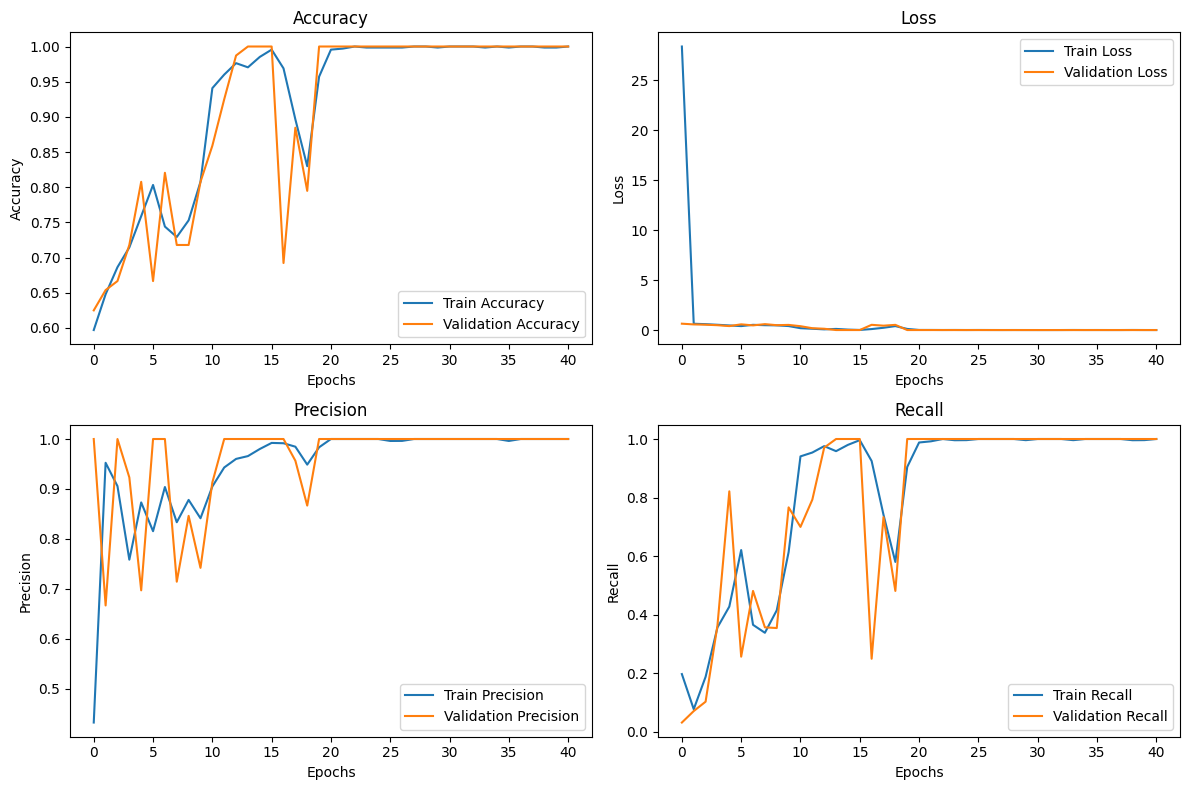

In [21]:
# Plot Accuracy, Loss, Precision, and Recall

# Access the metrics from the history object
# These metrics are tracked during training and validation for each epoch
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss
precision = history.history['Precision']  # Training precision
val_precision = history.history['val_Precision']  # Validation precision
recall = history.history['Recall']  # Training recall
val_recall = history.history['val_Recall']  # Validation recall

# Create subplots for better visualization
plt.figure(figsize=(12, 8))  # Create a figure with specified size

# Plot Accuracy
plt.subplot(2, 2, 1)  # First subplot in a 2x2 grid
plt.plot(acc, label='Train Accuracy')  # Plot training accuracy
plt.plot(val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.title('Accuracy')  # Set title for the plot
plt.xlabel('Epochs')  # Set x-axis label
plt.ylabel('Accuracy')  # Set y-axis label
plt.legend()  # Show the legend to differentiate training vs validation

# Plot Loss
plt.subplot(2, 2, 2)  # Second subplot in a 2x2 grid
plt.plot(loss, label='Train Loss')  # Plot training loss
plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
plt.title('Loss')  # Set title for the plot
plt.xlabel('Epochs')  # Set x-axis label
plt.ylabel('Loss')  # Set y-axis label
plt.legend()  # Show the legend

# Plot Precision
plt.subplot(2, 2, 3)  # Third subplot in a 2x2 grid
plt.plot(precision, label='Train Precision')  # Plot training precision
plt.plot(val_precision, label='Validation Precision')  # Plot validation precision
plt.title('Precision')  # Set title for the plot
plt.xlabel

# Model Evaluation on Test Set
This code evaluates the trained model on the test set using a video data generator. It calculates key metrics including test accuracy, precision, and recall, then prints the results.

In [27]:
# Evaluate the model on the test set

# Create a generator for the test data without augmentation
test_gen = video_generator(test_video_data, test_labels, batch_size, augment=False)

# Calculate the number of steps needed to iterate over the entire test set
steps = len(test_video_data) // batch_size

# Evaluate the model on the test set using the generator
# The function returns the loss, accuracy, precision, and recall
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_gen, steps=steps)

# Print the evaluation metrics: test accuracy, precision, and recall, formatted to 4 decimal places
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 474ms/step - Precision: 1.0000 - Recall: 0.9943 - accuracy: 0.9977 - loss: 0.1017   
Test Accuracy: 0.9875, Precision: 1.0000, Recall: 0.9688


# Single Video Preprocessing, Saving, and Loading
This code provides functions to preprocess a single video, save it in a numpy format, and load it later using memory-mapped mode for efficient access. It also includes functionality to randomly select and preprocess a video from labeled folders like 'shop lifters' or 'non shop lifters'.


In [109]:
# Function to preprocess and save a single video
def preprocess_and_save_single_video(video_path, label, target_frames=150, resize=(200, 200), save_dir='processed_videos'):
    """
    Preprocess and save a single video.
    
    Parameters:
    - video_path (str): Path to the input video file.
    - label (str): Label for the video (e.g., 'shop lifters' or 'non shop lifters').
    - target_frames (int): Target number of frames to extract from the video.
    - resize (tuple): Target dimensions to resize the frames to (width, height).
    - save_dir (str): Directory to save the processed video.
    """
    
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Assign label based on the input value
    label_value = 1 if label == 'shop lifters' else 0
    
    save_path = os.path.join(save_dir, f"video_label_{label_value}.npy")
    
    # Check if the video has already been processed and saved
    if os.path.exists(save_path):
        print(f"Skipping {save_path}, already processed.")
        return
    
    # Process and save the video
    frames = load_and_process_video(video_path, target_frames=target_frames, resize=resize)
    save_processed_video(frames, save_path)
    return save_path

In [105]:
# Function to load saved video using memory-mapped mode
def load_saved_video(save_dir, mmap_mode='r'):
    video_data = []
    labels = []
    
    # Check if the provided path is a directory
    # Ensure the directory exists before proceeding
    if not os.path.isdir(save_dir):
        print(f"Error: The provided path '{save_dir}' is not a valid directory.")
        return video_data, labels

    # Iterate through files in the directory
    # Process only .npy files, which contain the saved video data
    for file_name in tqdm.tqdm(os.listdir(save_dir)):
        if file_name.endswith('.npy'):
            file_path = os.path.join(save_dir, file_name)
            
            try:
                # Use memory-mapped loading for large files
                # This loads the video frames efficiently without consuming too much RAM
                frames = np.load(file_path, mmap_mode=mmap_mode)
                video_data.append(frames)
                
                # Extract the label from the filename (assuming format video_label_{label}.npy) 
                # The label is the last part of the filename before the extension
                parts = file_name.split('_')
                
                if len(parts) > 2:
                    label = parts[-1].split('.')[0]  # Extract the label from the filename
                else:
                    # Raise an error if the filename format is incorrect
                    raise ValueError(f"Filename format error: {file_name}")
                
                labels.append(label)
                
                # Return immediately after loading the first video
                # This exits the loop after loading the first video, useful for single video load scenarios
                break
            
            except Exception as e:
                # Handle errors during file loading and continue with other files
                print(f"Error loading {file_name}: {str(e)}")
                continue
    
    # Convert to NumPy arrays if possible
    try:
        # Convert video_data and labels to NumPy arrays for further processing
        video_data = np.array(video_data)
        labels = np.array(labels)
        print(f"Successfully converted data to NumPy arrays. Total videos loaded: {len(video_data)}")
    except ValueError as e:
        # Handle errors during conversion and return lists instead
        print(f"Error converting to array: {str(e)}")
        print("Returning lists of video data and labels instead of arrays.")
        return video_data, labels

    return video_data, labels

In [93]:
def select_random_video_and_preprocess(base_dir):
    variable_data = []
    variable_label = []
    
    # Define two folder categories: 'shop lifters' and 'non shop lifters'
    folders = ['shop lifters', 'non shop lifters']
    
    # Randomly select one of the folders (i.e., one class of videos)
    selected_folder = random.choice(folders)
    
    # Generate the full path to the selected folder
    folder_path = os.path.join(base_dir, selected_folder)

    # Get the list of all .mp4 video files in the selected folder
    video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]
    
    # If no videos are found, return None for both data and labels
    if not video_files:
        print(f"No videos found in folder: {selected_folder}")
        return None, None

    # Randomly select a video file from the list of available videos
    selected_video = random.choice(video_files)
    video_path = os.path.join(folder_path, selected_video)
    
    # Display the selected video and its corresponding folder (label)
    print(f"Selected video: {selected_video} from folder: {selected_folder}")

    # Remove the extension from the selected video filename
    video_name_without_extension = os.path.splitext(selected_video)[0]
    
    # Define the directory where preprocessed videos will be saved
    preprocessed_dir = os.path.join(base_dir, 'preprocessed')
    
    # Ensure that the 'preprocessed' directory exists
    os.makedirs(preprocessed_dir, exist_ok=True)

    # Define the save path for the preprocessed video (in .npy format)
    preprocessed_save_path = os.path.join(preprocessed_dir, f'preprocessed_{video_name_without_extension}.npy')
    
    # Preprocess and save the single video, and store the save path
    save_path = preprocess_and_save_single_video(video_path, selected_folder, save_dir=preprocessed_dir)
    
    # Final check to confirm if the file was saved successfully
    if not os.path.exists(save_path):
        # Print an error if the file was not saved
        print(f"Error: File not saved at {save_path}.")
    else:
        # Confirm that the file was successfully saved
        print(f"Successfully saved the file at {save_path}.")
    
    # Load the saved video data and label using memory-mapped loading
    variable_data, variable_label = load_saved_video(preprocessed_dir)
    
    # Return the loaded video data and label for further use
    return variable_data, variable_label

In [97]:
# Function to evaluate the model
def evaluate_model(model, variable_data, variable_label):
    # Make predictions using the model on the provided video data
    predictions = model.predict(variable_data)
    
    # Assuming binary classification, use a threshold (e.g., 0.5) to convert probabilities to class labels
    predicted_label = (predictions > 0.5).astype(int)

    # Compare predictions with actual labels for the first video
    print("Predicted Label:", predicted_label[0])
    print("Actual Label:", variable_label)

    # Calculate the total number of predictions
    total_predictions = len(predicted_label)
    
    # Count the number of predicted 'shop lifters' (label 1) and 'non-shop lifters' (label 0)
    shop_lifter_count = np.sum(predicted_label)
    non_shop_lifter_count = total_predictions - shop_lifter_count

    # Calculate the percentages of each label in the predictions
    shop_lifter_percentage = (shop_lifter_count / total_predictions) * 100
    non_shop_lifter_percentage = (non_shop_lifter_count / total_predictions) * 100

    # Print the calculated percentages for easier interpretation of results
    print(f"Percentage of Shop Lifters: {shop_lifter_percentage:.2f}%")
    print(f"Percentage of Non-Shop Lifters: {non_shop_lifter_percentage:.2f}%")

    # Return the predictions for further analysis or logging
    return predictions

In [110]:
variable_data, variable_label = select_random_video_and_preprocess(r"C:\Users\HP\Downloads\Shop DataSet\Shop DataSet")
if variable_data is not None and variable_label is not None:
     #Assuming 'model' is your trained model
    predictions = evaluate_model(model, variable_data, variable_label)
else:
    print("No video was selected or loaded.")

Selected video: shop_lifter_7.mp4 from folder: shop lifters
Preprocessed save path: C:\Users\HP\Downloads\Shop DataSet\Shop DataSet\preprocessed\preprocessed_shop_lifter_7.npy
Processed and saved video to C:\Users\HP\Downloads\Shop DataSet\Shop DataSet\preprocessed\video_label_1.npy.
Successfully saved the file at C:\Users\HP\Downloads\Shop DataSet\Shop DataSet\preprocessed\video_label_1.npy.


  0%|          | 0/1 [00:00<?, ?it/s]

Successfully converted data to NumPy arrays. Total videos loaded: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Label: [1]
Actual Label: ['1']
Percentage of Shop Lifters: 100.00%
Percentage of Non-Shop Lifters: 0.00%
